# Hochschule Bonn-Rhein-Sieg

# Mathematics for Robotics and Control

# Assignment 2 - Vectors, Matrices, Eigenvalues and Eigenvectors

Please write your name in this cell (and the names of all team members if working in a group):

* 
* 
*

Before we start with this assignment, let's setup the notebook so that we have all the packages we need for solving the exercises.

In [2]:
try:
    shell = get_ipython()
    shell.enable_pylab('inline')
except NameError:
    pass

import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
import IPython

**Hint**: Before you start solving the assignment, you might want to check out the following *numpy* functions:

```
linalg.eig
linalg.eigh
np.argmax
np.argmin
np.argsort
np.cov
np.mean
np.where
np.einsum
np.loadtxt
```

## Placing a package [55 points]

This exercise is concerned with matrices, particularly their eigenvalues and eigenvectors, such that our robot will have the task of bringing a package to a conference room and placing it on a flat surface (e.g. a table).

As you know from the previous assignment, the robot has already picked up a package and is now on its way to the office depicted below.

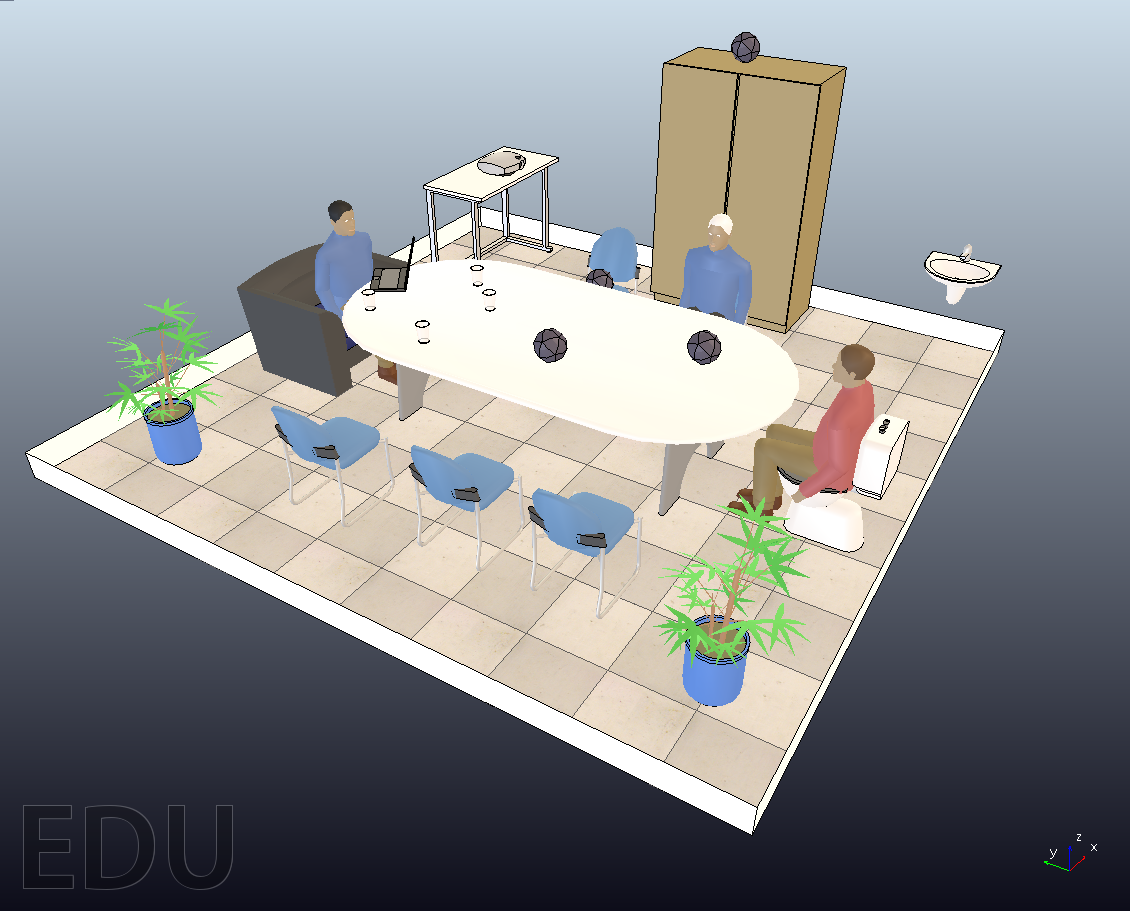

In [3]:
IPython.display.Image("images/isoview.png", width=800, embed=True)

The offices in the building are equipped with sensors that help the robot obtain the required data for carrying out its tasks. The office to which the robot is going now has an RGB-D sensor - a [Microsoft Kinect](https://en.wikipedia.org/wiki/Kinect) - mounted on the ceiling. RGB-D sensors can be used to obtain both a regular color image of a scene and what is called a depth image, in which each pixel encodes distances to the camera's sensor; these distances are typically given with respect to a reference frame whose origin is at the location of the camera's sensor.

Both images obtained in the office are depicted below. Note that darker blue colors in the depth image represent pixels that are farther away from the sensor.

In [ ]:
IPython.display.Image("images/rgb.png", width=800, embed=True)

In [ ]:
IPython.display.Image("images/depth.png", width=800, embed=True)

Depth images can be converted to a different data format, called a [*point cloud*](http://en.wikipedia.org/wiki/Point_cloud). A point cloud is a collection of 3-component tuples in which each component represents the coordinate of a point along a given axis. A formal definition of a point cloud $P$ is given below:

\begin{equation*}
    P = \{ (x, y, z) \lvert x,y,z \in \mathbb{R} \}
\end{equation*}

The picture below shows the aforementioned office scene as a point cloud obtained by the sensor mounted on the office's ceiling. Note that the unit of distance in the point cloud is **meters**.

In [ ]:
IPython.display.Image("images/pointcloud.png", width=800, embed=True)

If your browser supports WebGL and/or Adobe Flash, you can click [this link](http://www.pointclouds.org/assets/viewer/pcl_viewer.html?load=http://www.directlinkupload.com/uploads/194.95.66.1/cloud.pcd) for observing the point cloud in an interactive manner; otherwise, you can see the included *cloud.asc* or *cloud.ply* file in [MeshLab](http://meshlab.sourceforge.net/), or the included *cloud.pcd* file using *pcl_viewer*, which should be included in your ROS installation.

Notice the object "shadows" in the image above. Given what you know about how the point cloud is generated, think about why these shadows exist and what are they really are.

Now, back to our scenario. Our robot has already reached its destination and is now standing in front of the office door, after requesting sensor data from the central logistics unit and receiving the point cloud. **Your task is to identify possible drop points where the robot could place the package once inside the office**.

### Identifying feasible placement points [45 points]

In order to find feasible drop points for the package, you need to evaluate each point with respect to whether dropping off a package there would make sense; for that purpose, we need to obtain a new point cloud in which each point is associated with a quality measure. A simple quality measure would be the orientation of the [normal vector](https://en.wikipedia.org/wiki/Normal_%28geometry%29) of the underlying surface: given a point, if the surface to which the point belongs is not parallel to the floor, it would probably be unwise to place a package there. Note that normal vectors can be used for detecting tables, shelves and other furniture items commonly used for storing items.

Let us assume that our robot has knowledge of the world reference frame, i.e. it has an understanding of how the world is oriented; this is a reasonable assumption given a fixed robot construction and prior knowledge of the pose of the sensor used to obtain the point cloud data. In this case, we assume that the world frame is a subspace of $\mathbb{R}^3$ and that the orthonormal basis of the coordinate space is

\begin{equation*}
    B = \left\{ \begin{pmatrix}1 & 0 & 0\end{pmatrix}^T, \begin{pmatrix}0 & 1 & 0\end{pmatrix}^T, \begin{pmatrix}0 & 0 & 1\end{pmatrix}^T \right\}
\end{equation*}

To calculate the normal vectors of the points in the point cloud, you will implement a method described in [Surface reconstruction from unorganized points](http://hhoppe.com/recon.pdf), a (rather old) publication by Hoppe et al. You don't have to study the complete paper for implementing this method, as all relevant information is contained in section **3.2 (Tangent Plane Estimation)** of it.

As you will notice by reading this section, we need to find point neighbourhoods (referred to as *Nbhd(x)* in the paper) for calculating the normal vectors. In order to obtain such neighborhoods, we will use [*scipy.spatial.cKDTree*](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html), which is a spatial partitioning structure, and its method *query_ball_point*; we will use a radius of **$4cm$** and the [**L2 norm**](https://en.wikipedia.org/wiki/P-norm#The_p-norm_in_finite_dimensions) as a distance measure when calling this method.

Note: For the purposes of this assignment, you don't necessarily have to understand how a k-d tree works; the only thing you should know about it is that it is a structure that can be used for speeding up spatial neighborhood queries. If you are curious, however, there are many resources on k-d trees available on the web, such as [this collection of k-d tree visualisations](https://www.cs.cmu.edu/~awm/animations/kdtree/).

After obtaining a normal vector of each point's neighborhood, you need to calculate the angle between this normal vector and the $Z$-axis. The reasoning behind this is that a surface has to be parallel to the floor for it to be level; given that every surface parallel to the floor will have a normal vector pointing in the same direction as the $Z$-axis, the angle between the normal vector of the surface and the $Z$-axis is a measure of how level the surface is and shows whether a point is suitable for releasing a package. While performing this step, you need to be careful about points that yield no usable neighborhoods, e.g. points that are too far away from the other points; such points should not be processed. You can pass any value for the resulting angles of these points (except for values that are close to zero, as we will then mistakenly consider the points as being part of a level surface), but do **not** omit them from the final result.

Please implement the desired functionality by filling in the missing code in the cell below.

In [ ]:
'''Please write your name in this cell (and the names of all team members if working in a group:
-> Kabilan Tamilmani (ktamil2s)
-> Sahanesh Prakash (spraka2s)
-> Suraj Limbu (slimbu2s)
'''

import scipy.spatial

def get_angle (a :np.array,b:np.array) -> float:
    #Angle Between Two Vector
    theta = np.arccos(np.dot((a/np.linalg.norm(a)), 
                             (b/np.linalg.norm(b))))
    angle = min(abs(theta),abs(np.pi-theta))
    return angle
    
def rate_placements(point_cloud: np.array) -> np.array:
    angles = list()

    # YOUR CODE HERE
    
    #Base
    B = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
    #z-axis
    z_vector = B.T[2]
    
    #Initializing cKDTree class 
    MySpace = scipy.spatial.cKDTree(data=point_cloud)
    
    for data in point_cloud :
        #Finding Neighborhood points
        idx = MySpace.query_ball_point(x=data,r= (4/100),p =2.0)
        Nbhd= np.array([point_cloud[i] for i in idx])
        
        if(len(Nbhd)>1):
            #covariance_matrix of Neighborhood points
            covariance_matrix = np.cov(Nbhd.T)
            
            # eigenvalues, eigenvectors of covariance_matrix
            eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

            #Sorting based on eigen values high to low
            #Source:https://stackoverflow.com/questions/8092920
            idx = np.argsort(eigenvalues)[::-1]
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[:,idx]
            
            #Normal and angle between Normal and Z-axis
            n_vector = eigenvectors[2]
            angle = get_angle(n_vector,z_vector)
                
        else :
            #This points are far away from other points
            angle = np.deg2rad(45)
        
        #appendind angle to the angles list
        angles.append(angle)
    #raise NotImplementedError()
    return angles

#point_cloud = ### load cloud.asc here
point_cloud = np.loadtxt("data/cloud.asc")
angles = rate_placements(point_cloud)

### Visualising placement points [10 points]

After obtaining the normal vectors of the points in the point cloud, your task is to assign a color to each point by mapping the angles to a linearly segmented color space ranging from green to red, where green means *perfectly parallel to the ground*. You can use the [matplotlib.cm](http://matplotlib.org/api/cm_api.html) module for this task (see [Matplotlib Cookbook: Show Colormaps Example](http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps) for an example of using this module). Generally speaking, this step boils down to picking (or creating) a suitable colormap and applying the colormap to your angle values. Remember to convert the colors to a range of $[0, 255]$ before continuing with the next step.

The following cell shows a simple example on how to create and apply colormaps.

In [ ]:
# colormap example
f = plt.figure(figsize=(15, 5))
x = np.linspace(0, 4*np.pi, 500)
y = np.abs(np.sin(x))

plt.subplot(1,2,1)
colors = plt.cm.jet(y)
plt.scatter(x, y, c=colors)

plt.subplot(1,2,2)
colors = plt.cm.Accent(y)
plt.scatter(x, y, c=colors)

Please implement the functionality for mapping the angles to a suitable color space in the cell below.

In [ ]:
# YOUR CODE HERE
#Color Map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("MyColor",["green","red"])
RGBA = cmap(angles)

#color vector RGB (0 t0 255)
RGB = RGBA[:,:-1]*255
#raise NotImplementedError()

After you have obtained color values for each point, create a new $N \times M$ matrix, where $N$ is the number of points, while $M == 6$ corresponds to the $X, Y$ and $Z$ coordinates of each point and its $RGB$ color values (a tuple in the range $[0, 255]$). This matrix will then be passed to the function `save_as_ply`, which generates a file in the [Stanford Triangle Format](https://en.wikipedia.org/wiki/PLY_%28file_format%29). This function is implemented in the `utils.py` script that you have in your assignment directory.

In [ ]:
from utils import save_as_ply

### write your code here ###
point_cloud_rgb = np.hstack((point_cloud,RGB))
# YOUR CODE HERE
#raise NotImplementedError()
### your code ends here ###

save_as_ply('result.ply', point_cloud_rgb)

You can visualize your generated point cloud file using Meshlab or by using the command line utility **pcl_ply2pcd** and opening the resulting file in **pcl_viewer**. Both utilities come with an installation of PCL and should be included in your ROS installation.
<br /><br />

In any case, please generate an image of your solution, name the file `result.png`, place the file inside the `images` directory, and run the cell below to display the result.

In [ ]:
IPython.display.Image('images/result.png', width=800, embed=True)

Your solution should look similar to the one shown in the image below.

In [ ]:
IPython.display.Image('images/sample_result.png', width=800, embed=True)

## Disaster Site Observation [15 points]

You have been tasked to aerially survey a drop site (white square platform) of a disaster struck town. An autonomous drone is sent to retrive images of the drop site. The drone takes multiple images of the area, such that an edge detection module is used to obtain the corners of the platform. At any time, three corners of the platform are clearly visible; the module records the positions of the corner pixels in the image as 2D vectors w.r.t the left bottom corner of the image.

The images are stored along with the data of the platform. The data is provided in the file `site_position.txt`, where each row gives the 2D vectors of the three drop site corners in a single image in the following order (see figure below):

```
brown_colored_corner, blue_colored_corner, red_colored_corner
```

Here, each colored corner has the `x` and `y` coordinates respectively, so there are six values in each row.

Your task is to filter out the images which have a bad perspective of the drop site. The end objective is to return the indices of the top 24 images with the best perspective of the drop site.

_Note_ : The indices begin from `0`.

In [ ]:
IPython.display.Image('images/site_perspective.png', width=800, embed=True)

Understand how the condition number changes for different matrices and then apply it in order to obtain the 24 images with the best perspective of the drop site.

In [7]:
# YOUR CODE HERE
site_position = np.loadtxt('site_position.txt')
brown_colored_corner, blue_colored_corner, red_colored_corner = np.hsplit(site_position,3)

def lineFromPoints(A,B):
    #function to find the line equation
    x = B[0] - A[0]
    y = B[1] - A[1]
    return [x,y]

#Evaluating ConditionNumber
ConditionNumber = []
for i in range(0,len(site_position)):
    v_1 = lineFromPoints(brown_colored_corner[i],blue_colored_corner[i])
    v_2 = lineFromPoints(blue_colored_corner[i],red_colored_corner[i])
    A = np.vstack((v_1,v_2))
    ConditionNumber.append(np.linalg.cond(A))

#sorting
best_indices = np.argsort(ConditionNumber)[:24]
print(best_indices)

[56 36  9 67 64 12 88 34 19 69 55 42 53 21 80 20 54 51 37 78 60 84 68 70]


In [ ]:
### THIS CELL CONTAINS AUTOMATED TESTS OF YOUR SOLUTION; DO NOT DELETE IT!


## Corona Time [10 points]

You are the mayor of Roboville and covid-19 has struck your town. You have deployed various robots to combat this pandemic. Initially, 80% of the robots are healthy, while the rest are temporarily broken.

Based on past information of the robots, we have the following statistics:
* after each week, 5% of the healthy robots break down
* 80% of the broken robots are repairable, while the rest are non-repairable
* 85% of the repaired robots get completely fixed (i.e. they become healthy), while the rest break down again

Since you have to arrange the service centers for the broken robots, you would like to develop a forecast model that uses the above information for obtaining the percentage of broken robots in the future.

[5 points] What is the percentage of broken robots after 5 weeks?

In [2]:
# YOUR CODE HERE

#Healthy-A, Broken-B, Repairable-C, Non-Repairable-D
AA = 0.95
AB = 0.05
AC = 0
AD = 0
BA = 0
BB = 0
BC = 0.8
BD = 0.2
CA = 0.85
CB = 0.15
CC = 0
CD = 0
DA = 0
DB = 0
DC = 0
DD = 1
#T = np.array([[AA, BA, CA, DA],[AB, BB, CB, DB],[AC, BC, CC, DC], [AD, BD, CD, DD]])
T = np.array([[.95, 0, .85, 0 ], [.05,.0,.15, 0], [0,.80, 0, 0],[0,.20,0, 1]])
x0 = np.array([0.8, 0.2,0, 0])[np.newaxis].T #Initial State
x = x0
for i in range(5):
    x = T.dot(x)
#raise NotImplementedError()
broken_5 = x[1] * 100
print(broken_5)

[4.784125]


In [3]:
### THIS CELL CONTAINS AUTOMATED TESTS OF YOUR SOLUTION; DO NOT DELETE IT!


[2 points] Now, assume that this scenario continues for a very long time (potentially forever). What is the long term  percentage of healthy robots, broken robots, repairable robots and non-repairable robots?

In [4]:
# YOUR CODE HERE
#function to calculate the eigen values and eigen vectors
def get_chain_eigenvalues_and_eigenvectors(T: np.array) -> tuple:
    eigenvalues, eigenvectors = np.linalg.eig(T)
    return (eigenvalues, eigenvectors)
#function to calculate the fixed point
def extract_fixed_point(eigenvalues: np.array, eigenvectors: np.array) -> np.array:
    fixed_point = eigenvectors[:,np.where(np.abs(eigenvalues - 1.) < 1e-5)[0][0]]
    return fixed_point
#function to convert fixed point to probabilty
def convert_to_probability_vector(vector: np.array) -> np.array:
    #print(np.sum(vector))
    p = vector / np.sum(vector)
    return p
eigenvalues, eigenvectors = get_chain_eigenvalues_and_eigenvectors(T)
fixed_point = extract_fixed_point(eigenvalues, eigenvectors)
fixed_point = convert_to_probability_vector(fixed_point)
healthy = fixed_point[0] * 100
broken = fixed_point[1] * 100
repairable = fixed_point[2] * 100
non_repairable = fixed_point[3] * 100
print("Healthy",healthy)
print("Broken",broken)
print("Repairable",repairable)
print("Non-repairable", non_repairable)

Healthy 0.0
Broken 0.0
Repairable 0.0
Non-repairable 100.0


In [5]:
### THIS CELL CONTAINS AUTOMATED TESTS OF YOUR SOLUTION; DO NOT DELETE IT!


[3 points] Due to the above rather unfavourable prediction, you have recruited specialists who have completed the MAS course. Now, after each week, 20% of non-repairable robot can in fact be fixed. What would the long term state of the robots be now?

In [6]:
# YOUR CODE HERE

DA = 0.2
DD = 0.8
A = np.array([[.95, 0, .85, .20], [.05,.0,.15, 0.], [0,.80, 0., 0.],[0,.20,0,.80]])
eigenvalues, eigenvectors = get_chain_eigenvalues_and_eigenvectors(A)
fixed_point = extract_fixed_point(eigenvalues, eigenvectors)
fixed_point = convert_to_probability_vector(fixed_point)
healthy = fixed_point[0] * 100
broken = fixed_point[1] * 100
repairable = fixed_point[2] * 100
non_repairable = fixed_point[3] * 100
print("Healthy",healthy)
print("Broken",broken)
print("Repairable",repairable)
print("Non-repairable", non_repairable)

Healthy 86.27450980392162
Broken 4.901960784313704
Repairable 3.921568627450965
Non-repairable 4.901960784313724


In [ ]:
### THIS CELL CONTAINS AUTOMATED TESTS OF YOUR SOLUTION; DO NOT DELETE IT!
